<a href="https://colab.research.google.com/github/hws2002/ThinkBayes2/blob/main/CH7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install empiricaldist

In [98]:
import numpy as np
from empiricaldist import Pmf

hypos = np.linspace(0, 1, 101) # 0과 1 을 포함해서 101개의 일정 한 간격을 만듦
pmf = Pmf(1, hypos)
data = 140, 250

In [99]:
from scipy.stats import binom

def update_binomial(pmf, data):
  """ 이항분포를 사용한 pmf 갱신 """
  k, n = data
  xs = pmf.qs
  likelihood = binom.pmf(k, n, xs)
  pmf *= likelihood
  pmf.normalize()

update_binomial(pmf, data)

In [100]:
cumulative = pmf.cumsum()

<Axes: >

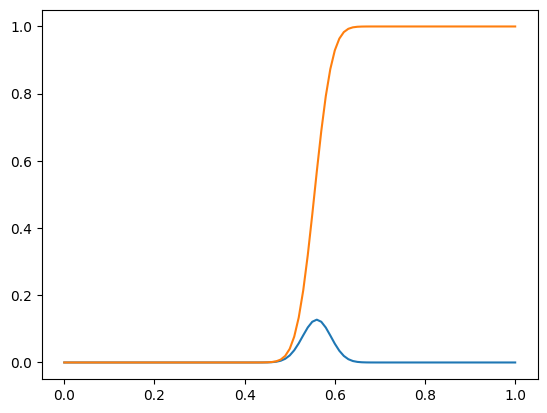

In [101]:
pmf.plot()
cumulative.plot()

보간법을 이용한 방식

In [102]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps,qs)
interp(0.96)

array(0.60890171)

empiricaldist에서는 누적분포함수를 나타내는 클래스인 Cdf를 사용할 수 있다.  

In [103]:
cdf = pmf.make_cdf() # np.cumsum()을 사용해서 확률의 누적합을 구한다.

In [104]:
cdf.quantile(0.9638303)

array(0.61)

In [105]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

## 7.2 넷 중 높은 값

In [106]:
def make_die(sides):
  outcomes = np.arange(1, sides + 1)
  die = Pmf(1/sides, outcomes)
  return die

In [107]:
def add_dist_seq(seq):
  total = seq[0]
  for other in seq[1:]:
    total = total.add_dist(other)
  total.normalize()
  return total

In [108]:
dice = Pmf(1, np.arange(1,7))
dice = [dice] * 3
dice

[1    1
 2    1
 3    1
 4    1
 5    1
 6    1
 dtype: int64,
 1    1
 2    1
 3    1
 4    1
 5    1
 6    1
 dtype: int64,
 1    1
 2    1
 3    1
 4    1
 5    1
 6    1
 dtype: int64]

In [109]:
pmf_3d6 = add_dist_seq(dice)

<Axes: >

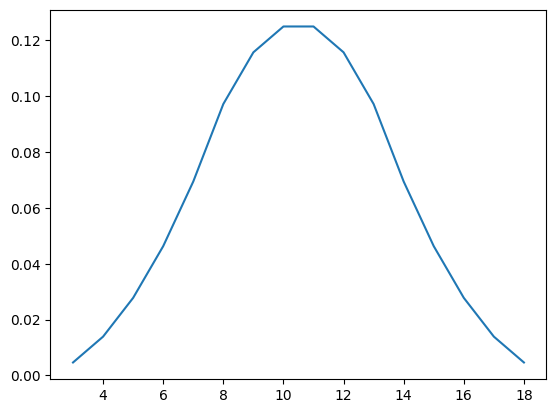

In [110]:
pmf_3d6.plot()


육면체 주사위 4개를 굴린 후, 이 중 3개의 높은 값을 더한다고 할때, 결과값의 분포는 은근 구하기 어렵다.  

먼저 10,000번의 시도를 시뮬레이션 해 분포를 추정해 보자.

In [111]:
n = 10000
a = np.random.randint(1, 7, size = (n,4))

In [112]:
a = np.sum(a, axis = 1) - np.min(a, axis = 1)

In [113]:
a

array([17, 13,  6, ...,  9,  9, 14])

In [114]:
import matplotlib.pyplot as plt

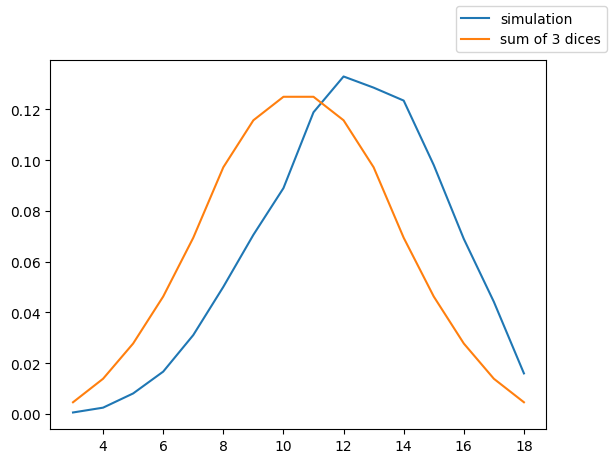

In [115]:
pmf_best3 = Pmf.from_seq(a)
fig, ax = plt.subplots()
pmf_best3.plot(label = 'simulation')
pmf_3d6.plot(label = 'sum of 3 dices')
fig.legend()

# 7.3 최댓값

주사위를 4번 던져서 가장 작은 값을 제외하고 더한 값이 x보다 작은 확률을 구해보고, 이 행위를 6번 반복했을때, 그 값들이(합) 모두 x보다 작을 확률을 구해보자.

먼저 cdf를 구한다.  
cdf(x)는 x보다 같거나 작은 값에 대한 확률의 합임을 기억하자.

In [116]:
cdf_best3 = pmf_best3.make_cdf()

이제 이 분포를 6제곱하면, 위에 서술한 분포의 cdf를 구할 수 있다.

In [117]:
cdf_best3 ** 6

,
3,4.665600e-20
4,8.875037e-16
5,1.973823e-12
6,4.716558e-10
7,4.218053e-08
8,1.686353e-06
9,3.367352e-05
10,3.763622e-04
11,3.390803e-03
12,1.990788e-02


<Axes: >

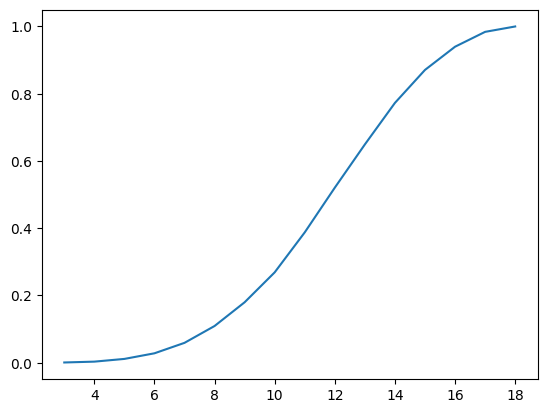

In [118]:
cdf_best3.plot()

Cdf에는 max_dist()를 통해 동일한 계산을 할 수 있다.

In [119]:
cdf_max_dist6 = cdf_best3.max_dist(6)

이를 Cdf객체를 사용해서 저장하자

In [120]:
from empiricaldist import Cdf

cdf_max6 = Cdf(cdf_best3**6)

# 7.4 최솟값

이번에는 그 값들의 최소값이 x보다 작을 확률을 구해보자.

이는 먼저 상호보완 CDF를 사용해야 한다

In [121]:
prob_gt = 1 - cdf_best3

<Axes: >

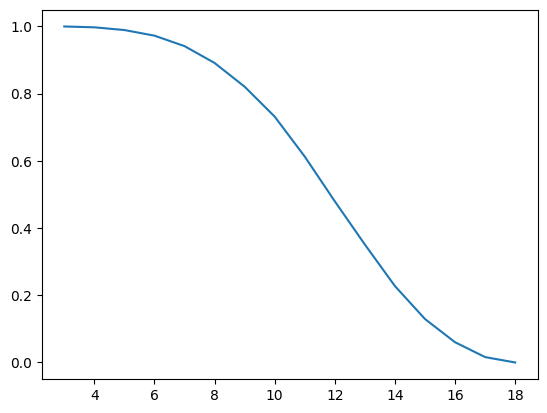

In [122]:
prob_gt_c = prob_gt.copy()
prob_gt.plot()

이를 6제곱하면, 6번의 시행에서 그 값들이 모두 x보다 클 확률이 된다.   
즉, 최소값이 x보다 크거나 같은 경우의 확률이다.

In [123]:
prob_gt = prob_gt ** 6

<Axes: >

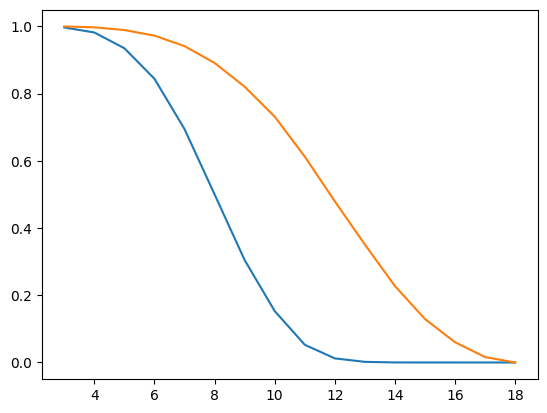

In [124]:
prob_gt.plot()
prob_gt_c.plot()

그럼 최소값이 x보다 작거나 같은 경우는?  
상호보완 CDF를 사용하면 된다.

In [125]:
prob_le6 = 1 - prob_gt

In [126]:
cdf_min6 = Cdf(prob_le6)

Cdf에는 동일한 기능을 하는 min_dist()가 있다

In [127]:
cdf_min_dist6 = cdf_best3.min_dist(6)

## 7.5 혼합


In [128]:
d4 = make_die(4)
d6 = make_die(6)

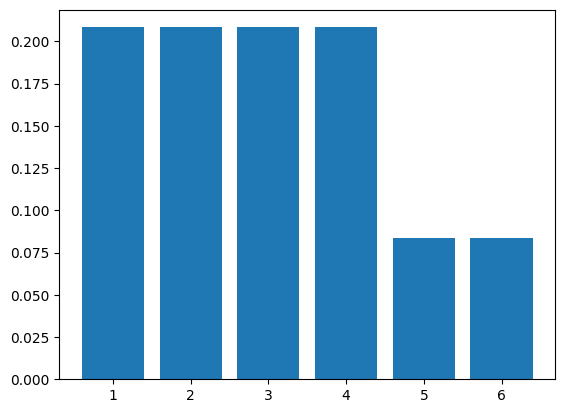

In [129]:
mix1 = (d4 + d6) / 2
mix1.bar()

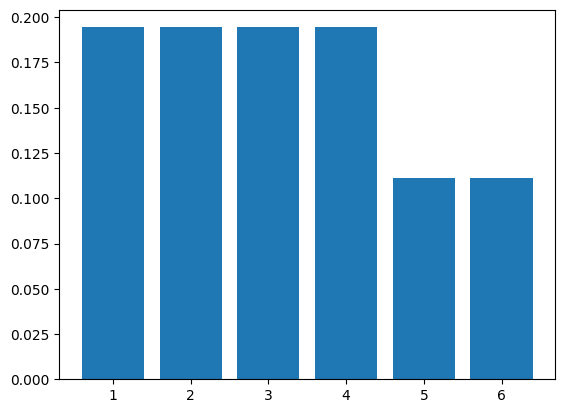

In [130]:
mix2 = (d4 + 2*d6) / 3
mix2.bar()

# 7.6 일반적인 혼합

In [131]:
hypos = [4,6,8]
counts = [1,2,3] # weights
pmf_dice = Pmf(counts, hypos) # 빈도수, index
pmf_dice.normalize()
pmf_dice

,0
4,0.166667
6,0.333333
8,0.500000


각 주사위의 pmf 객체를 만든다

In [132]:
dice = [make_die(sides) for sides in hypos]
dice

[1    0.25
 2    0.25
 3    0.25
 4    0.25
 dtype: float64,
 1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 dtype: float64,
 1    0.125
 2    0.125
 3    0.125
 4    0.125
 5    0.125
 6    0.125
 7    0.125
 8    0.125
 dtype: float64]

혼합분포를 구하기 위해, pmf_dice의 확률값을 가중치로 해서 주사위의 가중평균을 구해보자

In [133]:
import pandas as pd

pd_mix = pd.DataFrame(dice)

In [134]:
pd_mix.fillna(0)

,1,2,3,4,5,6,7,8
0,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000,0.000
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000,0.000
2,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


In [135]:
df = pd_mix.transpose().fillna(0)

In [136]:
df *= pmf_dice.ps
df

,0,1,2
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


In [137]:
df.sum(axis = 1)

,0
1,0.159722
2,0.159722
3,0.159722
4,0.159722
5,0.118056
6,0.118056
7,0.062500
8,0.062500


위 과정을 하나로 모든 가중 혼합분포를 만드는 함수를 생성해보자

In [138]:
def make_mixture(pmf, pmf_seq):
  """ 혼합분포를 만든다. """
  df = pd.DataFrame(pmf_seq).fillna(0).transpose()
  df *= np.array(pmf)
  total = df.sum(axis = 1)
  return Pmf(total)

In [139]:
mix = make_mixture(pmf_dice, dice)

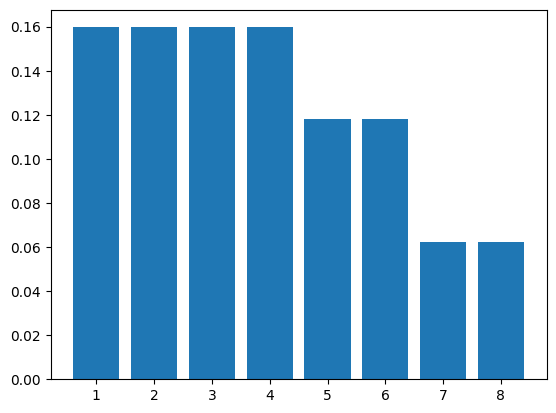

In [140]:
mix.bar()

# 7.8 연습 문제

## 문제 7-1

### 먼저 분포의 평균을 구해보자

In [141]:
# 기본 분배값의 평균
standard = [15, 14, 13, 12 ,10, 8]
pmf_standard = Pmf(1, standard)
pmf_standard.normalize()
pmf_standard.mean()

12.0

In [142]:
pmf_best3.mean()

12.216000000000001

기대값은 주사위를 굴리는 것이 조금 더 높다

### 어떤 분포의 표준 편차가 더 큰가?

In [143]:
pmf_standard.std()

2.3804761428476167

In [144]:
pmf_best3.std()

2.853058709525621

표준편차는 pmf_best3가 약간 더 크다

### 기본 분배값의 최솟값은 8이다. 각 능력치에서, 8보다 더 작은 값이 나올 확률은 얼마인가?

In [175]:
cdf_best3 = pmf_best3.make_cdf()
cdf_best3[7]

0.059

### 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 8보다 낮을 확률은 얼마인가?

이는 1에서 모든 능력치가 8보다 클 확률을 빼면 된다.  
먼저 6번 굴렸을 때 모든 능력치가 8보다 클 확률(최소값이 8보다 클 확률)을 구해보자

In [161]:
cdf_gt  = 1 - cdf_best3

In [162]:
cdf_gt = cdf_gt ** 6

In [163]:
cdf_le = 1- cdf_gt

In [176]:
cdf_le[7]

0.3057150669502601

이는 min_dist() 함수를 써서 풀 수도 있다.

In [165]:
cdf_min_dist = cdf_best3.min_dist(6)

In [177]:
cdf_min_dist[7]

0.3057150669502601

### 기본 분배값의 최댓값은 15이다. 각 능력치에서, 15보다 더 큰 값이 나올 확률은 얼마인가?

<Axes: >

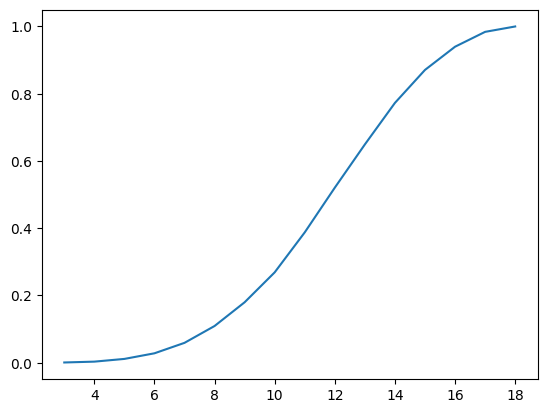

In [168]:
cdf_best3.plot()

In [169]:
# 주사위를 굴렸을때 15보다 더 큰 값이 나올 확률
1 - cdf_best3[15]

0.1292000000000001

#### 주사위를 6번 굴렸을 때, 최소 하나 이상의 능력치가 15보다 클 확률은?

이번에는 최댓값 분포를 사용하면 된다

In [179]:
cdf_max_dist= cdf_best3.max_dist(6)
1 - cdf_max_dist[15]

0.5639758720068615

## 문제 7-2

앞전에 구현했던 make_mixture()를 사용해서 풀어보자

In [196]:
monsters = [6,8,10]
prior = Pmf(1, monsters)
prior

,0
6,1
8,1
10,1


In [197]:
likelihood = Pmf(1,monsters, dtype = "float64")
for q in likelihood.qs:
  likelihood[q] = 1/q
likelihood

,0
6,0.166667
8,0.125000
10,0.100000


In [200]:
posterior = prior * likelihood
posterior.normalize()
posterior

,0
6,0.425532
8,0.319149
10,0.255319


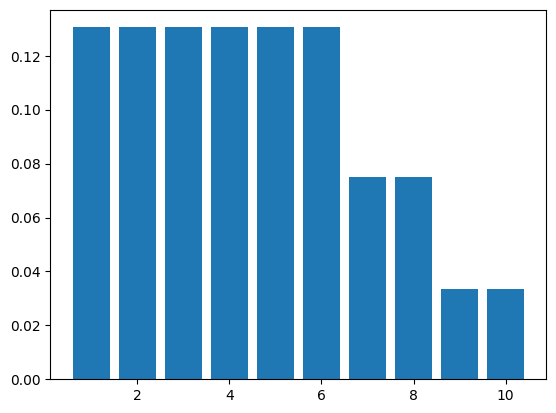

In [204]:
pmf_seq = [make_die(sides) for sides in monsters]
mix = make_mixture(prior, pmf_seq)
mix.normalize()
mix.bar()

In [205]:
mix[6]

0.13055555555555554

## 문제 7-3

In [244]:
num_simul = 10000
ns = [10,20,50,100,1000]
df = pd.DataFrame(index = ns)
for n in ns:
  a = np.random.normal(0.95,0.05,(num_simul,n))
  a = np.max(a, axis = 1)
  df.loc[n,'MaxValue_min'] = a.mean()
df

,MaxValue_min
10,1.026934
20,1.043418
50,1.062789
100,1.075823
1000,1.111975


n이 커질수록 오히려 최댓값 평균이 1,000g을 넘어간다.  
n의 범위를 다시 잡고 해보자

In [249]:
ns = np.linspace(1, 10, 10, dtype = "int64")
df = pd.DataFrame(index = ns)
for n in ns:
  a = np.random.normal(0.95,0.05,(num_simul,n))
  a = np.max(a, axis = 1)
  df.loc[n,'MaxValue_min'] = a.mean()
df

,MaxValue_min
1,0.949760
2,0.978153
3,0.992048
4,1.001462
5,1.007660
6,1.012875
7,1.017796
8,1.020772
9,1.023715
10,1.027061


n이 4~5개 정도일때 1,000g에 가깝다는 것을 알 수 있다.

(이 문제는 정확도를 고려했을때 단위를 kg보다 g으로 하는게 더 나앗을 것 같다,)

각 분포들의 cdf도 도식화해서 비교해보자.

<Axes: >

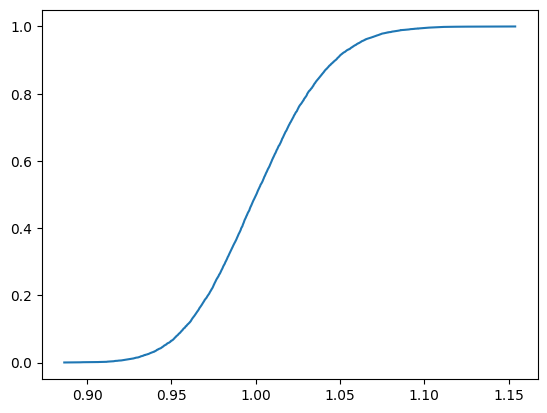

In [256]:
a4 = np.random.normal(0.95, 0.05, (num_simul,4))
a4 = np.max(a4, axis = 1)
cdf_max4 = Cdf.from_seq(a4)
cdf_max4.plot()

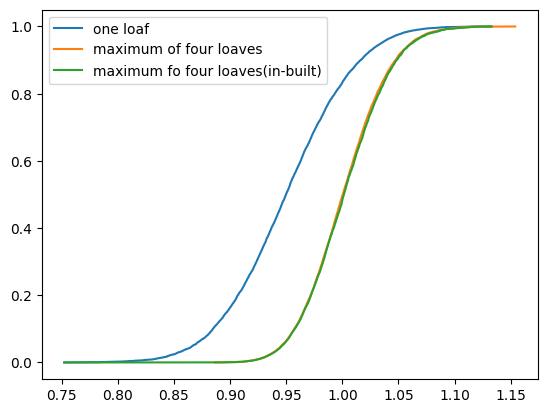

In [261]:
a = np.random.normal(0.95, 0.05, (num_simul))
cdf = Cdf.from_seq(a)
cdf_max4_inbuilt = cdf.max_dist(4)

cdf.plot(label = "one loaf")
cdf_max4.plot(label = "maximum of four loaves")
plt.legend()